In [1]:
# imports
from copy import deepcopy
import numpy as np
from statistics import mean

import sys
sys.path.append('../src/')

from classification import get_stumps
from evaluation import central_train_accuracy, central_test_accuracy, edges, central_loss
from network import synthetic_graph, get_alphas
from related_works import colearning, alternating_colearning
from optimization import regularized_local_FW, local_FW, gd_reg_local_FW, centralized_FW
from utils import generate_fixed_moons, get_min_max

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# set graph of nodes with local personalized data
NB_ITER = 10000
D = 20
n = 200
NOISE_R = 0.05
random_state = 2017

BETA = 10

K, X, Y, X_test, Y_test, max_nb_instances, theta_true, angles, groundtruth_adj_matrix = generate_fixed_moons(D, sample_error_rate=NOISE_R, rnd_state=2017)

# set graph
nodes, adj_matrix, similarities = synthetic_graph(X, Y, X_test, Y_test, K, theta_true, max_nb_instances)

# set monitors for optimization analysis
monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'loss': [central_loss, []],
}

# get weak classifiers
vmin, vmax = get_min_max(X)
base_clfs = get_stumps(n=n, d=D+1, min_v=vmin, max_v=vmax)

results = {}

colors = {
    "global l1 Adaboost": "g",
    "purely local models": "k",
    "Dada exponential": "b",
    "personalized linear": "m", 
    "Dada": "c",
    "personalized linear gd": "y",
}

In [3]:
nodes_copy = deepcopy(nodes)
results["Dada exponential"] = regularized_local_FW(nodes_copy, base_clfs, beta=BETA, nb_iter=NB_ITER, 
                                mu=1, monitors=monitors, checkevery=100)

In [4]:
centralized_nodes = deepcopy(nodes)
centralized_FW(centralized_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["global l1 Adaboost"] = {}
results["global l1 Adaboost"]["train-accuracy"] = central_train_accuracy(centralized_nodes)
results["global l1 Adaboost"]["test-accuracy"] = central_test_accuracy(centralized_nodes)

local_nodes = deepcopy(nodes)
local_FW(local_nodes, base_clfs, beta=BETA, nb_iter=1000, monitors={})
results["purely local models"] = {}
results["purely local models"]["train-accuracy"] = central_train_accuracy(local_nodes)
results["purely local models"]["test-accuracy"] = central_test_accuracy(local_nodes)

# global_nodes = deepcopy(nodes)
# global_regularized_local_FW(global_nodes, base_clfs, beta=BETA, nb_iter=NB_ITER, monitors={})
# results["global-local mixture"] = {}
# results["global-local mixture"]["train-accuracy"] = central_train_accuracy(global_nodes)
# results["global-local mixture"]["test-accuracy"] = central_test_accuracy(global_nodes)

In [5]:
results["personalized linear"], clf_colearning = colearning(K, X, Y, X_test, Y_test, D, NB_ITER, adj_matrix, 
                                similarities, mu=1, max_samples_per_node=max_nb_instances, checkevery=100)

In [6]:
from evaluation import kalo_objective
from optimization import kalo_graph_discovery

# graph discovery
gd_pace = 500

MU, LA = 0.1, 100

monitors = {
    'train-accuracy': [central_train_accuracy, []],
    'test-accuracy': [central_test_accuracy, []],
    'edges': [edges, []],
    'obj-function': [kalo_objective, [MU, LA]],
}

gd_nodes = deepcopy(nodes)
results["Dada"] = gd_reg_local_FW(gd_nodes, base_clfs, gd_method={"name":"kalo", "pace_gd": gd_pace, 
                    "args":(MU, LA)}, beta=BETA, mu=MU, nb_iter=NB_ITER, monitors=monitors, checkevery=100)

# Accuracy and Convergence

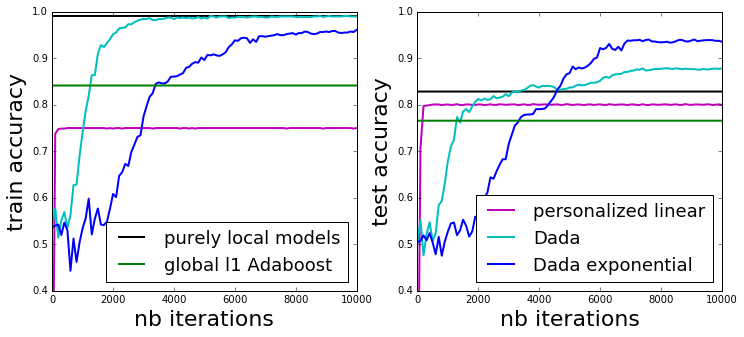

In [7]:
plt.figure(1, figsize=(12, 5))

max_iter = NB_ITER
plt.subplot(121)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = k
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '_nolegend_'
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['train-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['train-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

plt.subplot(122)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(0.4, 1)

for k, r_list in results.items():
    label = '_nolegend_'
    if k in ['Dada exponential', 'Dada', 'personalized linear']:
        label = '{}'.format(k)
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['test-accuracy'] for r in r_list], label=label, color=colors[k], linewidth=2)
    except:
        plt.plot(range(NB_ITER+1), [r_list['test-accuracy']]*(NB_ITER+1), label=label, color=colors[k], linewidth=2)

plt.legend(loc='lower right', fontsize=18)

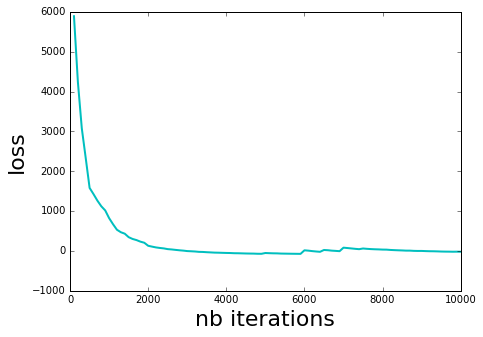

In [8]:
# convergence

max_iter = NB_ITER
plt.figure(1, figsize=(7, 5))

plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('loss', fontsize=22)

for k, r_list in results.items():
    try:
        plt.plot([i*100 for i in range(len(r_list))], [r['obj-function'] for r in r_list], label=k, color=colors[k], linewidth=2)
    except:
        pass

# plt.legend(loc='upper right', fontsize=22)

Dada 23.24


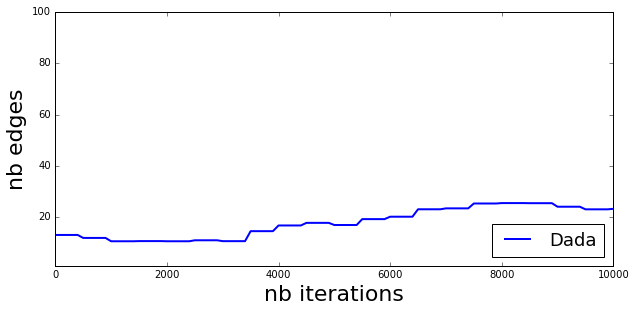

In [9]:
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('nb iterations', fontsize=22)
plt.ylabel('nb edges', fontsize=22)
plt.xlim(0, max_iter)
plt.ylim(1, K)

for k, r_list in results.items():
    try:
        print(k, np.mean(r_list[-1]['edges']))
        plt.plot([i*100 for i in range(len(r_list))], [np.mean(r['edges']) for r in r_list], label=k, linewidth=2)
    except:
        pass

plt.legend(loc='lower right', fontsize=18)

## Graph correlations

In [10]:
from scipy.stats import spearmanr

matrix_angles = np.empty((K, K))
for i in range(K):
    for j in range(K):
        matrix_angles[i, j] = abs(angles[i] - angles[j])

print("Correlation with angles")
print("kalo", spearmanr(matrix_angles, results["Dada"][-1]["similarities"], axis=None))

print("\nCorrelation with similarities")
print("kalo", spearmanr(similarities, results["Dada"][-1]["similarities"], axis=None))

Correlation with angles
kalo SpearmanrResult(correlation=-0.42406308552388383, pvalue=0.0)

Correlation with similarities
kalo SpearmanrResult(correlation=0.48612331692769101, pvalue=0.0)


In [11]:
def get_edges_weights(adj_matrix, similarities):
    edges = []
    weights = []
    for i in range(K):
        for j in range(i, K):
            if adj_matrix[i, j]:
                edges.append((i, j))
                weights.append(similarities[i, j])
    return edges, weights

In [25]:
import networkx as nx

STEP = gd_pace
kalo_graph = nx.from_numpy_matrix(results["Dada"][-1]["adj-matrix"])
kalo_edges, kalo_weights = get_edges_weights(results["Dada"][-1]["adj-matrix"], results["Dada"][-1]["similarities"])

groundtruth_graph = nx.from_numpy_matrix(adj_matrix)
gr_edges, gr_weights = get_edges_weights(adj_matrix, similarities)

# pos_kalo = nx.spring_layout(kalo_graph)
pos = nx.spring_layout(kalo_graph)

print("number of  non-negligible edges", sum(results["Dada"][-1]["edges"]))
for i in [10**j for j in range(-6, 2)]:
    print("nb edges w >", i, ":", np.count_nonzero(results["Dada"][-1]["similarities"] > i))

number of  non-negligible edges 2324
nb edges w > 1e-06 : 2406
nb edges w > 1e-05 : 2396
nb edges w > 0.0001 : 2258
nb edges w > 0.001 : 2156
nb edges w > 0.01 : 2138
nb edges w > 0.1 : 2048
nb edges w > 1 : 1022
nb edges w > 10 : 0


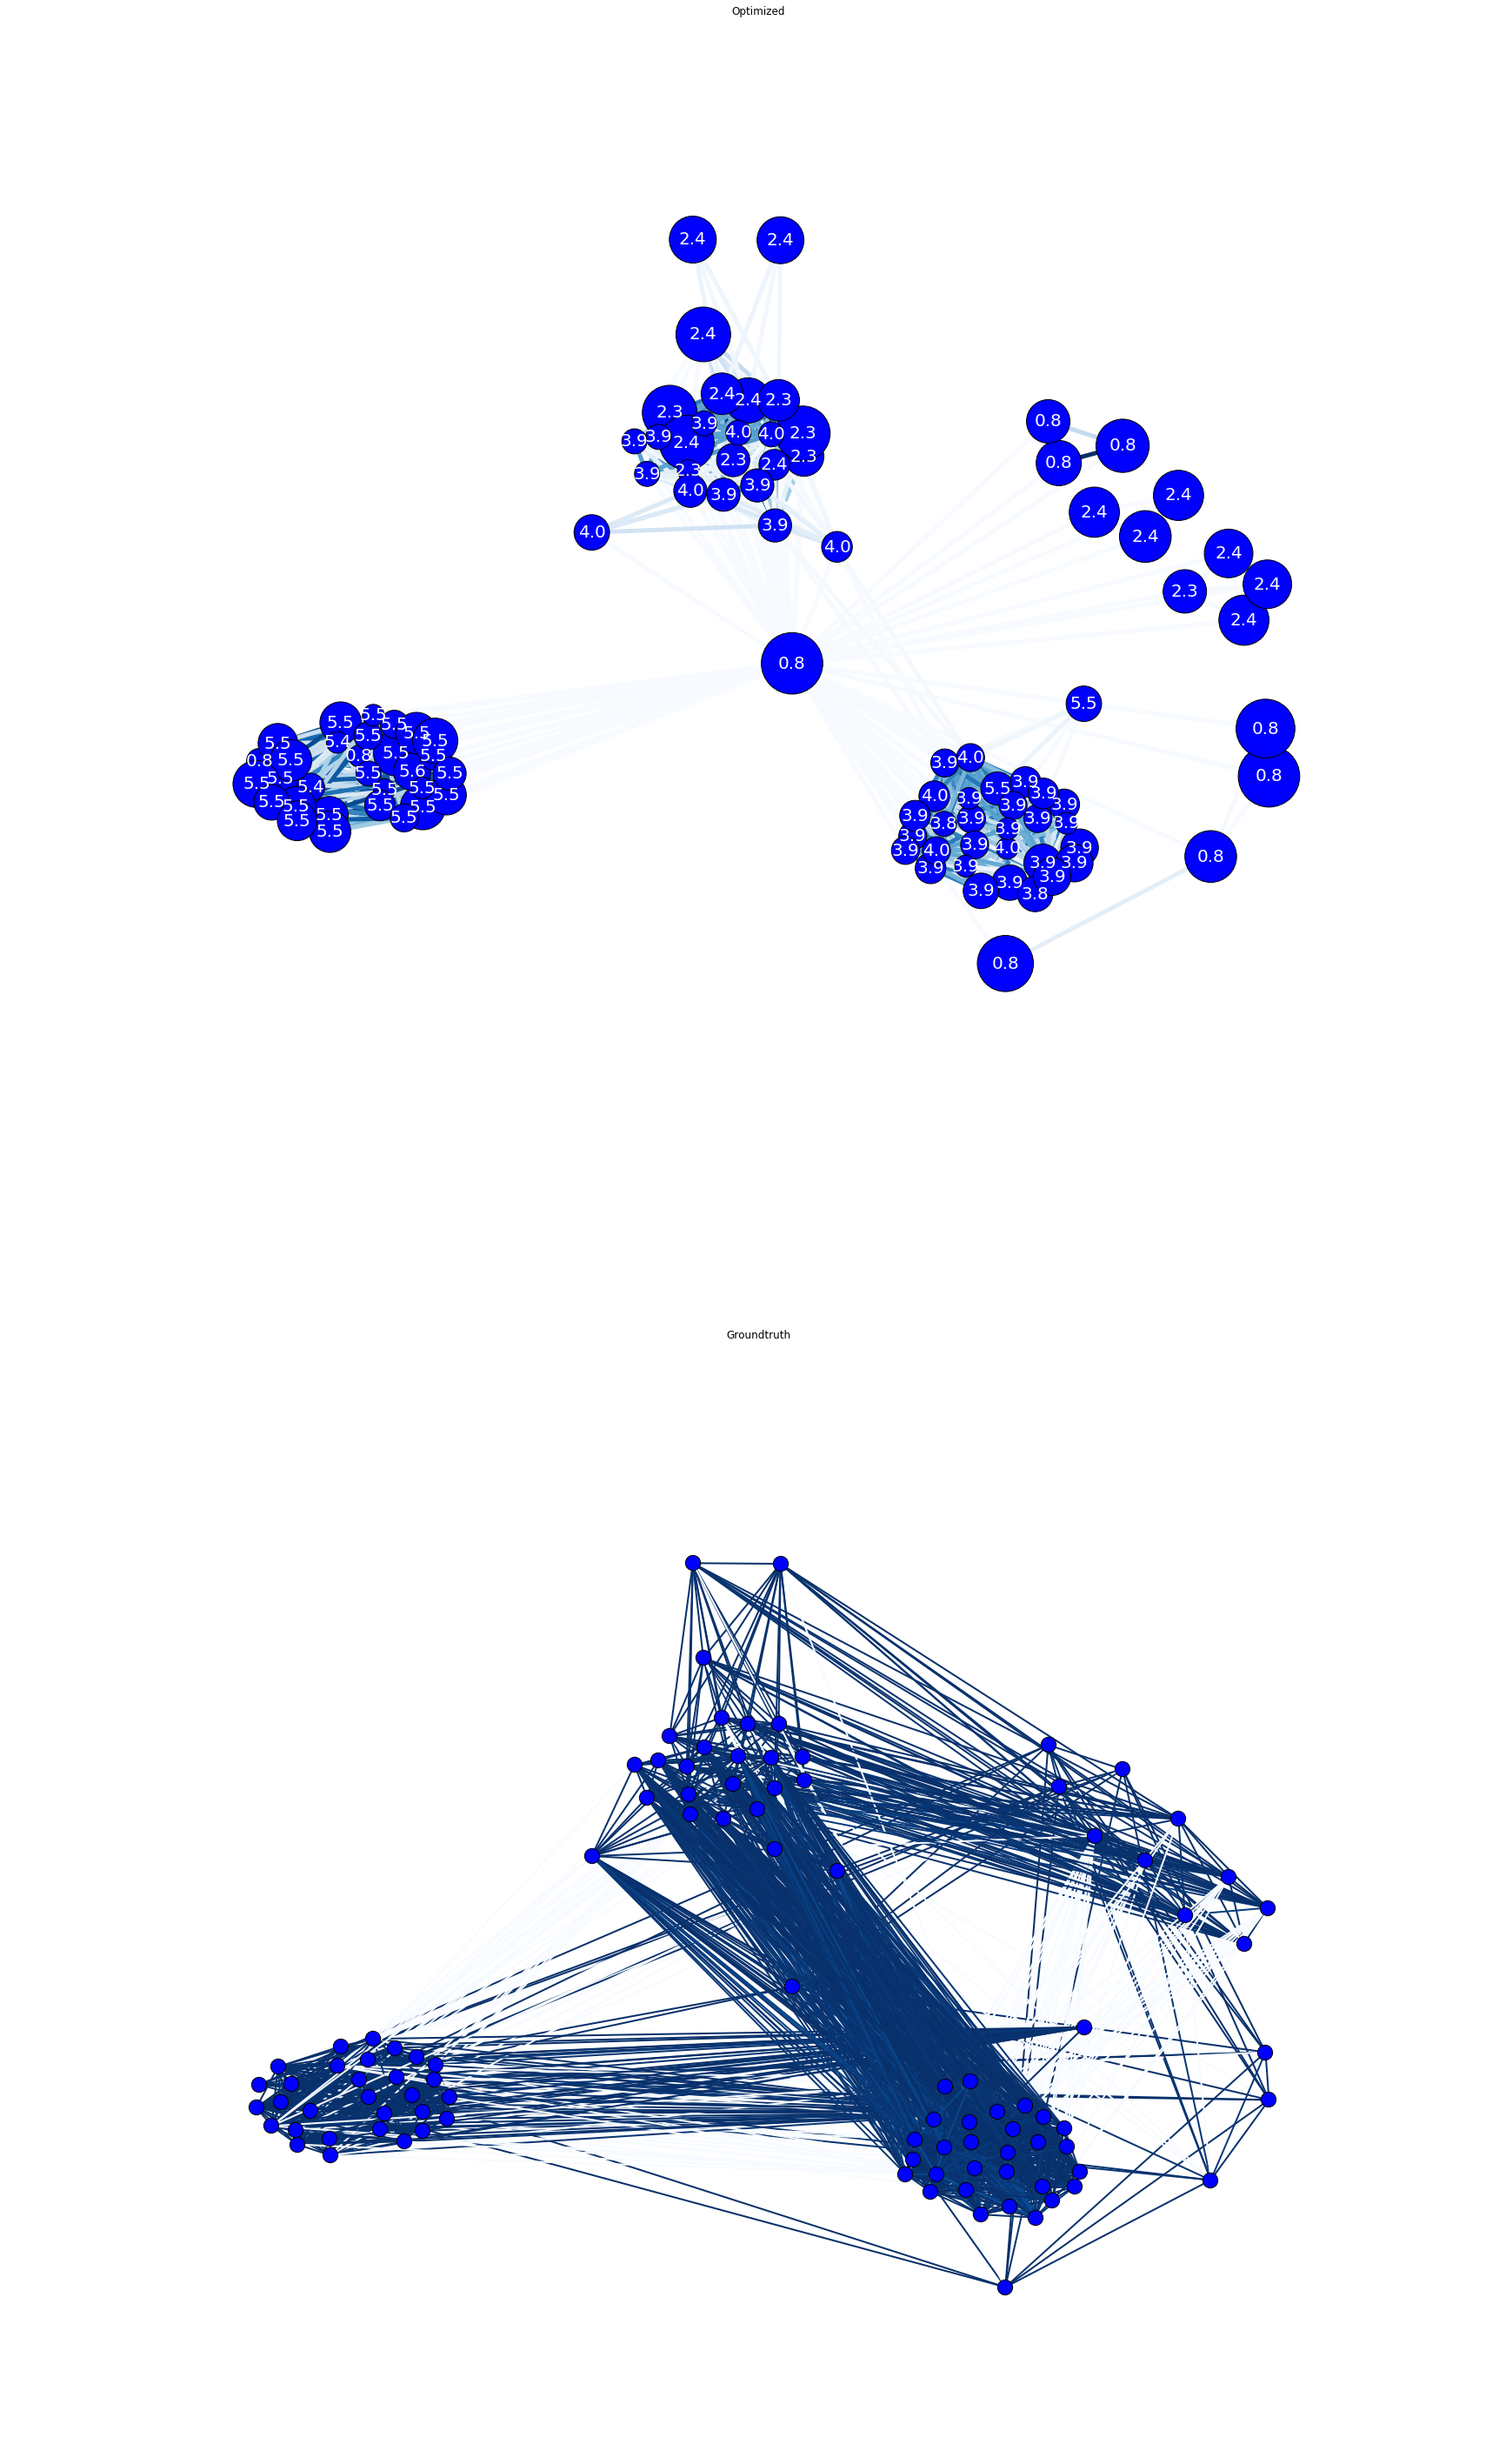

In [27]:
plt.figure(1, figsize=(30, 50))

plt.subplot(211)
plt.title('Optimized')
nx.draw(kalo_graph, pos, node_color='b', node_size=[n.confidence*5000 for n in nodes], edgelist=kalo_edges, edge_color=kalo_weights, width=5.0, edge_cmap=plt.cm.Blues)
nx.draw_networkx_labels(kalo_graph, pos, labels={i:round(a, 1) for i,a in enumerate(angles)}, font_size=20, font_color='w', alpha=1.0, ax=None)

plt.subplot(212)
plt.title('Groundtruth')
nx.draw(groundtruth_graph, pos, node_color='b', edgelist=gr_edges, edge_color=gr_weights, width=2.0, edge_cmap=plt.cm.Blues)

## Accuracy vs sparsity


In [31]:
B_LIST = [j * 10**i for i in range(-3, 3) for j in range(1, 10, 2)]
results_kalo = {}
# results_kalo = {}.fromkeys(B_LIST, {"train-accuracy": [], "test-accuracy": [], "mean-edges": []})
NB_ITER = 10000

gd_pace = 500

for b in B_LIST:
    print(b)
    results_kalo[b] = {"train-accuracy": [], "test-accuracy": [], "mean-edges": []}

    for _ in range(2):
                
        init_w = kalo_graph_discovery(local_nodes, MU, b)
        gd_nodes = deepcopy(nodes)
        gd_reg_local_FW(gd_nodes, base_clfs, init_w, gd_method={"name":"kalo", "pace_gd": gd_pace, "args":(MU, b)},
                        beta=BETA, mu=MU, reset_step=False, nb_iter=NB_ITER, monitors={}, checkevery=100)

        results_kalo[b]["train-accuracy"].append(central_train_accuracy(gd_nodes))
        results_kalo[b]["test-accuracy"].append(central_test_accuracy(gd_nodes))        
        results_kalo[b]["mean-edges"].append(np.mean(edges(gd_nodes)))

for b in B_LIST:
    results_kalo[b]["train-accuracy"] = np.mean(results_kalo[b]["train-accuracy"])    
    results_kalo[b]["test-accuracy"] = np.mean(results_kalo[b]["test-accuracy"])
    results_kalo[b]["mean-edges"] = np.mean(results_kalo[b]["mean-edges"])


1 0.0001


KeyboardInterrupt: 

In [ ]:
# sort reaults
train = {}
test = {}
for k, value in results_kalo.items():
    try:
        train[value["mean-edges"]].append(value["train-accuracy"])
    except:
        train[value["mean-edges"]] = [value["train-accuracy"]]
    
    try:
        test[value["mean-edges"]].append(value["test-accuracy"])
    except:
        test[value["mean-edges"]] = [value["test-accuracy"]]

train_sorted_keys = sorted(train.keys())    
test_sorted_keys = sorted(test.keys())    

{1.6666666666666667: [0.84333333333333338], 2.3333333333333335: [0.89000000000000001], 3.8333333333333335: [0.81083333333333329], 5.166666666666667: [0.78666666666666663], 9.8333333333333339: [0.78000000000000003], 11.0: [0.8075, 0.81666666666666665, 0.80083333333333329], 5.833333333333333: [0.81083333333333329]}


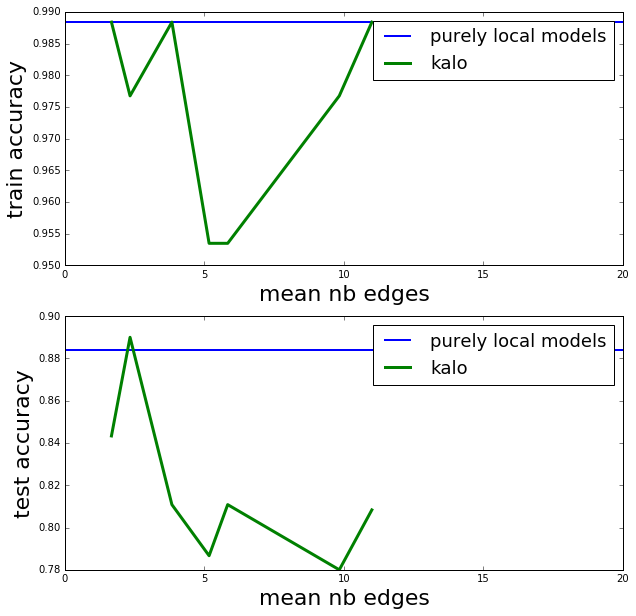

In [16]:
plt.figure(1, figsize=(10, 10))

plt.subplot(211)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('train accuracy', fontsize=22)
plt.xlim(1, K)
# plt.ylim(0.5, 1.1)

plt.plot([1, K], [results['purely local models']['train-accuracy']]*2, label='purely local models', linewidth=2)
plt.plot(train_sorted_keys, [np.mean(train[k]) for k in train_sorted_keys], label='kalo', linewidth=3)
# plt.scatter([value[] for k, value in results_kalo.items()], [], linewidth=1)

plt.legend(loc='center right', fontsize=18)

plt.subplot(212)
plt.xlabel('mean nb edges', fontsize=22)
plt.ylabel('test accuracy', fontsize=22)
plt.xlim(1, K)
# plt.ylim(0.5, 1.1)

plt.plot([1, K], [results['purely local models']['test-accuracy']]*2, label='purely local models', linewidth=2)
plt.plot(test_sorted_keys, [np.mean(test[k]) for k in test_sorted_keys], label='kalo', linewidth=3)

plt.legend(loc='center right', fontsize=18)